## First Look

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024) max=1


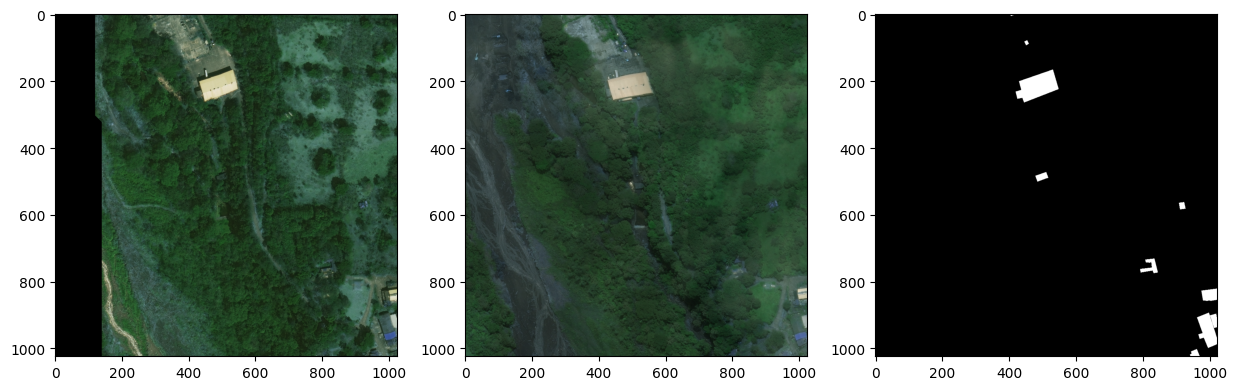

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tifffile as tf

import json
from pprint import pprint

img_pre = cv2.imread('/storage/alperengenc/change_detection/xBD_complete_png/train/images/guatemala-volcano_00000000_pre_disaster.png')
img_post = cv2.imread('/storage/alperengenc/change_detection/xBD_complete_png/train/images/guatemala-volcano_00000000_post_disaster.png')
img_target = cv2.imread('/storage/alperengenc/change_detection/xBD_complete_png/train/targets/guatemala-volcano_00000000_post_disaster_target.png', 0)
print(img_pre.shape)
print(img_post.shape)
print(img_target.shape, f"max={np.max(img_target)}")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_pre)

plt.subplot(1, 3, 2)
plt.imshow(img_post)

plt.subplot(1, 3, 3)
plt.imshow(img_target, cmap='gray')



In [4]:
total_pixels = np.multiply(*img_target.shape)
print("total number of pixels:", total_pixels) # total number of pixels in the target image
print("white pixel value:", img_target.max()) # white pixel value
print("black pixel value:", img_target.min()) # black pixel value
white_pixels = img_target.sum() # number of white pixels (if white=1, black=0)
print("number of white pixels:", white_pixels) # number of white pixels (if white=1, black=0)
print(f"white pixel ratio: {100 * white_pixels / total_pixels : .2f}%", ) # number of white pixels (if white=1, black=0)

total number of pixels: 1048576
white pixel value: 1
black pixel value: 0
number of white pixels: 15838
white pixel ratio:  1.51%


In [6]:
# import json
# from pprint import pprint

label = json.load(open("/storage/alperengenc/change_detection/xBD_complete_png/train/labels/guatemala-volcano_00000000_post_disaster.json"))
pprint(label)

{'features': {'lng_lat': [{'properties': {'feature_type': 'building',
                                          'subtype': 'no-damage',
                                          'uid': '486b0813-ecd2-4b84-856c-9c0e42156953'},
                           'wkt': 'POLYGON ((-90.81544679490855 '
                                  '14.39086318334812, -90.81537467350067 '
                                  '14.39060467857134, -90.81584174451893 '
                                  '14.39043032647906, -90.81586635209965 '
                                  '14.39049581582557, -90.81593344431286 '
                                  '14.39048145754227, -90.81595559689623 '
                                  '14.39057367091926, -90.81587964155047 '
                                  '14.39059650626524, -90.81590706308843 '
                                  '14.39071123556855, -90.81544679490855 '
                                  '14.39086318334812))'},
                          {'properties': {'feature

## Statistical Analysis

In [2]:
# 2025.09.19

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tifffile as tf
import glob
import os.path
from dataclasses import dataclass
from tqdm import tqdm

@dataclass
class DataPaths:
    pre_img: str
    post_img: str
    pre_target: str
    post_target: str
    stem: str
    """base name; without path, pre-post suffix and extension."""
    

# BASE_PATH = "/storage/alperengenc/change_detection/xBD_complete_png/train_combined"
BASE_PATH = "/mnt/storage1/alpgenc/change_detection/xBD_complete_png/train_combined"
all_pre_images = glob.glob(f"{BASE_PATH}/images/*_pre_disaster.png")

all_data: list[DataPaths] = []

print(f"Generating paths in {BASE_PATH} ...")
for i, pre_img_path in enumerate(all_pre_images):
    post_img_path = pre_img_path.replace("pre", "post")
    img_base, _, _ = pre_img_path.rsplit("_", 2) # path/to/images/malawi-cyclone_00000342_pre_disaster.tif

    target_base = img_base.replace("images", "targets")
    pre_target_path = f"{target_base}_pre_disaster_target.png"
    post_target_path = f"{target_base}_post_disaster_target.png"

    stem = os.path.basename(img_base)

    all_data.append(DataPaths(pre_img_path, post_img_path, pre_target_path, post_target_path, stem))
print(f"Done, {len(all_data) = }")

damage_levels_dict = {
    0: "Not Building",
    1: "No Damage",
    2: "Minor Damage",
    3: "Major Damage",
    4: "Destroyed"
}

max_levels = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
dmg_level_existences = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
dmg_level_pixel_counts = {1: 0, 2: 0, 3: 0, 4: 0}
for data in tqdm(all_data):
    post_target = cv2.imread(data.post_target, cv2.IMREAD_GRAYSCALE)

    maxlvl = post_target.max()
    max_levels[maxlvl] += 1

    unq = np.unique(post_target)
    for val in unq:
        dmg_level_existences[val] += 1
        if val != 0:
            dmg_level_pixel_counts[val] += (post_target == val).sum()

total_pix_count = sum(dmg_level_pixel_counts.values())

print("=== Statistics ===")
print("All Data:", len(all_data))
print("Number of images that doesn't contain any buildings:", max_levels[0])
print("Number of images that doesn't contain any damaged buildings:", max_levels[1])
print("Number of images with at most Minor Damage level:", max_levels[2])
print("Number of images with at most Major Damage level:", max_levels[3])
print("Number of images with at most Destroyed level:", max_levels[4])
print(" *** ")
print("Number of images that contain backround:", dmg_level_existences[0])
print("Number of images that contain undamaged buildings:", dmg_level_existences[1])
print("Number of images that contain Minor Damage level:", dmg_level_existences[2])
print("Number of images that contain Major Damage level:", dmg_level_existences[3])
print("Number of images that contain Destroyed level:", dmg_level_existences[4])
print(" *** ")
print(f"Ratio of undamaged pixels: {dmg_level_pixel_counts[1] / total_pix_count:.4%}")
print(f"Ratio of Minor Damage pixels: {dmg_level_pixel_counts[2] / total_pix_count:.4%}")
print(f"Ratio of Major Damage pixels: {dmg_level_pixel_counts[3] / total_pix_count:.4%}")
print(f"Ratio of Destroyed pixels: {dmg_level_pixel_counts[4] / total_pix_count:.4%}")


Generating paths in /mnt/storage1/alpgenc/change_detection/xBD_complete_png/train_combined ...
Done, len(all_data) = 9168


100%|██████████| 9168/9168 [01:33<00:00, 97.55it/s] 

=== Statistics ===
All Data: 9168
Number of images that doesn't contain any buildings: 3674
Number of images that doesn't contain any damaged buildings: 2254
Number of images with at most Minor Damage level: 463
Number of images with at most Major Damage level: 736
Number of images with at most Destroyed level: 2041
 *** 
Number of images that contain backround: 9168
Number of images that contain undamaged buildings: 4624
Number of images that contain Minor Damage level: 1785
Number of images that contain Major Damage level: 1797
Number of images that contain Destroyed level: 2041
 *** 
Ratio of undamaged pixels: 76.3496%
Ratio of Minor Damage pixels: 8.6312%
Ratio of Major Damage pixels: 8.9949%
Ratio of Destroyed pixels: 6.0243%


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tifffile as tf
import glob
import os.path
from dataclasses import dataclass
from tqdm import tqdm

@dataclass
class DataPaths:
    pre_img: str
    post_img: str
    pre_target: str
    post_target: str
    stem: str
    """base name; without path, pre-post suffix and extension."""
    

# BASE_PATH = "/storage/alperengenc/change_detection/xBD_complete_png/train_combined"
TEST_BASE_PATH = "/mnt/storage1/alpgenc/change_detection/xBD_complete_png/test"
_all_pre_images = glob.glob(f"{TEST_BASE_PATH}/images/*_pre_disaster.png")

all_test_data: list[DataPaths] = []

print(f"Generating paths in {TEST_BASE_PATH} ...")
for i, pre_img_path in enumerate(_all_pre_images):
    post_img_path = pre_img_path.replace("pre", "post")
    img_base, _, _ = pre_img_path.rsplit("_", 2) # path/to/images/malawi-cyclone_00000342_pre_disaster.tif

    target_base = img_base.replace("images", "targets")
    pre_target_path = f"{target_base}_pre_disaster_target.png"
    post_target_path = f"{target_base}_post_disaster_target.png"

    stem = os.path.basename(img_base)

    all_test_data.append(DataPaths(pre_img_path, post_img_path, pre_target_path, post_target_path, stem))
print(f"Done, {len(all_test_data) = }")

damage_levels_dict = {
    0: "Not Building",
    1: "No Damage",
    2: "Minor Damage",
    3: "Major Damage",
    4: "Destroyed"
}

max_levels = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
dmg_level_existences = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
dmg_level_pixel_counts = {1: 0, 2: 0, 3: 0, 4: 0}
for data in tqdm(all_test_data):
    post_target = cv2.imread(data.post_target, cv2.IMREAD_GRAYSCALE)

    maxlvl = post_target.max()
    max_levels[maxlvl] += 1

    unq = np.unique(post_target)
    for val in unq:
        dmg_level_existences[val] += 1
        if val != 0:
            dmg_level_pixel_counts[val] += (post_target == val).sum()

total_pix_count = sum(dmg_level_pixel_counts.values())

print("=== Statistics ===")
print("All Test Data:", len(all_test_data))
print("Number of images that doesn't contain any buildings:", max_levels[0])
print("Number of images that doesn't contain any damaged buildings:", max_levels[1])
print("Number of images with at most Minor Damage level:", max_levels[2])
print("Number of images with at most Major Damage level:", max_levels[3])
print("Number of images with at most Destroyed level:", max_levels[4])
print(" *** ")
print("Number of images that contain backround:", dmg_level_existences[0])
print("Number of images that contain undamaged buildings:", dmg_level_existences[1])
print("Number of images that contain Minor Damage level:", dmg_level_existences[2])
print("Number of images that contain Major Damage level:", dmg_level_existences[3])
print("Number of images that contain Destroyed level:", dmg_level_existences[4])
print(" *** ")
print(f"Ratio of undamaged pixels: {dmg_level_pixel_counts[1] / total_pix_count:.4%}")
print(f"Ratio of Minor Damage pixels: {dmg_level_pixel_counts[2] / total_pix_count:.4%}")
print(f"Ratio of Major Damage pixels: {dmg_level_pixel_counts[3] / total_pix_count:.4%}")
print(f"Ratio of Destroyed pixels: {dmg_level_pixel_counts[4] / total_pix_count:.4%}")


Generating paths in /mnt/storage1/alpgenc/change_detection/xBD_complete_png/test ...
Done, len(all_test_data) = 933


100%|██████████| 933/933 [00:07<00:00, 125.77it/s]

=== Statistics ===
All Test Data: 933
Number of images that doesn't contain any buildings: 194
Number of images that doesn't contain any damaged buildings: 257
Number of images with at most Minor Damage level: 57
Number of images with at most Major Damage level: 137
Number of images with at most Destroyed level: 288
 *** 
Number of images that contain backround: 933
Number of images that contain undamaged buildings: 570
Number of images that contain Minor Damage level: 244
Number of images that contain Major Damage level: 294
Number of images that contain Destroyed level: 288
 *** 
Ratio of undamaged pixels: 76.6715%
Ratio of Minor Damage pixels: 8.2977%
Ratio of Major Damage pixels: 9.6654%
Ratio of Destroyed pixels: 5.3654%


In [3]:
import cv2
import numpy as np
from tqdm import tqdm

print("PRE DISASTER TARGETS SHOULD CONTAIN ONLY [0, 1] PIXEL VALUES. CHECK VALUES:")
incorrect_count = 0
for d in tqdm(all_data):
    im = cv2.imread(d.pre_target, cv2.IMREAD_GRAYSCALE)
    unq = np.unique(im)
    if (np.unique((0)) == unq).all(): # might be only background
        continue
    if unq.size != 2 or (np.unique((0,1)) != unq).any():
        print(f"{d.pre_target}: {unq}")
        incorrect_count += 1
print(f"{incorrect_count = }")


PRE DISASTER TARGETS SHOULD CONTAIN ONLY [0, 1] PIXEL VALUES. CHECK VALUES:


100%|██████████| 9168/9168 [01:28<00:00, 103.61it/s]

incorrect_count = 0


In [5]:
from tqdm import tqdm
import os.path

################################################################################################################

print("Warning; create data paths (all_data) in the previous cells before running this.")

################################################################################################################

def create_train_test_lists2(base_path: str, test_base_path: str, all_data: list[DataPaths],  all_test_data: list[DataPaths]):
    with open(f"{base_path}/train_list2.txt", "w") as f:
        for d in all_data:
            f.write(f"{d.stem}\n")
        print(f"Generated: {os.path.realpath(f.name)}")

    with open(f"{test_base_path}/test_list2.txt", "w") as f:
        for d in all_test_data:
            f.write(f"{d.stem}\n")
        print(f"Generated: {os.path.realpath(f.name)}")

################################################################################################################

TRAIN_RATIO = 0.80

create_train_test_lists2(BASE_PATH, TEST_BASE_PATH, all_data, all_test_data)




Warning; create data paths (all_data) in the previous cells before running this.
Generated: /mnt/storage1/alpgenc/change_detection/xBD_complete_png/train_combined/train_list2.txt
Generated: /mnt/storage1/alpgenc/change_detection/xBD_complete_png/test/test_list2.txt


### Target Image (mask) Creation 
[DEPRECATED - USE ``dataset_create_target-masks.py``] 

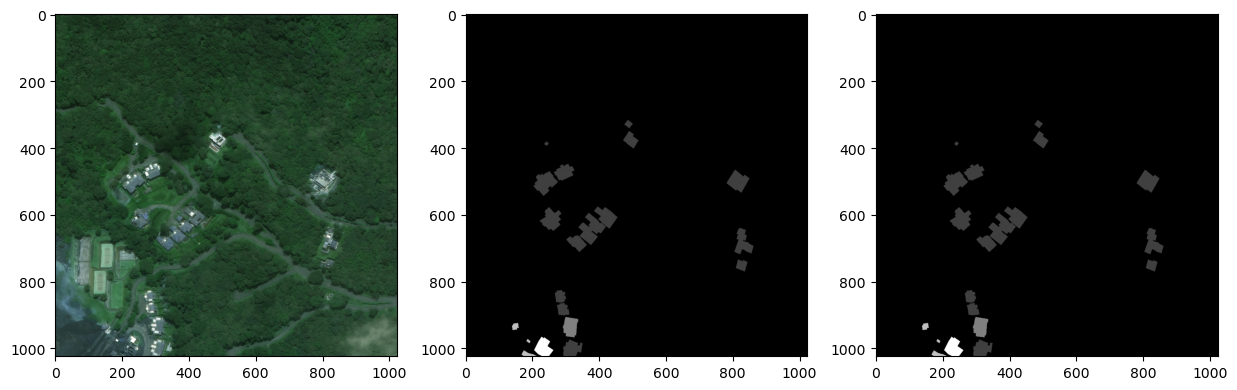

Ground truth non-zero: 31843
Created mask non-zero: 31820
Incorrect pixel count: 23 ( 0.072%)


np.float64(0.0722293753729234)

In [1]:
##################################################################################################################
# IMPORTANT NOTE (2025.08.06): cv2.fillPoly outputs vary slightly depending on the cv2 (maybe numpy) versions.
# env: changemamba2, python: 3.10.15, opencv-python: 4.10.0.84, numpy: 2.1.2 --> error: 0%
# env: vision      , python: 3.13.5 , opencv-python: 4.12.0   , numpy: 2.3.2 --> error: 0.072%
##################################################################################################################


import os
import json
import numpy as np
from PIL import Image
from shapely import wkt
from shapely.geometry import Polygon
# import rasterio.features
# from rasterio.transform import Affine # for identity transform but not necessary, can also be omitted
from matplotlib import pyplot as plt
import cv2


exp_post_imgfile        = "/storage/alperengenc/change_detection/Xbd/train/images/guatemala-volcano_00000019_post_disaster.png" # experimental image file
exp_post_target_imgfile = f"{exp_post_imgfile}".replace('images', 'targets').replace('.png', '_target.png') # correct target image file (ground truth)
exp_post_lblfile        = f"{exp_post_imgfile}".replace('images', 'labels' ).replace('.png', '.json') # correct label file (ground truth)

##################################################################################################################

DAMAGE_MAPPING = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4
}
def create_target_mask_from_label2(label_json_path, out_shape=(1024, 1024)) -> np.ndarray:
    with open(label_json_path, 'r') as f:
        label_data = json.load(f)

    xy_features = label_data['features'].get("xy", [])
    if not xy_features:
        print("No xy features found in labels")
        return None

    mask = np.zeros(out_shape, dtype=np.uint8)
    for xy_feat in xy_features:
        props = xy_feat['properties']
        damage_type = props.get('subtype')
        damage_level = DAMAGE_MAPPING.get(damage_type, 1)  # Default to 1 (building no-damage) if type is not found.
        # if damage_type not in DAMAGE_MAPPING:
        #     print(f"Unknown damage type: {damage_type} in {label_json_path}. Skipping the feature.")
        #     continue
        polygon = wkt.loads(xy_feat['wkt'])
        pxcoords = np.array(polygon.exterior.coords)
        pxcoords = np.round(pxcoords).astype(np.int32)
        cv2.fillPoly(mask, [pxcoords], damage_level)
        # print(pxcoords.shape, pxcoords) # TODO delete: DEBUG

    return mask


def check_target_error(generated_target: np.ndarray, expected_target: np.ndarray, verbose: bool = False):
    diff_img = np.where(expected_target != generated_target, 1, 0)
    incorrect_pixel_count = diff_img.sum()
    ground_truth_non_zero = np.where(expected_target > 0, 1, 0).sum()
    generated_mask_non_zero = np.where(generated_target > 0, 1, 0).sum()
    if ground_truth_non_zero == 0:
        if generated_mask_non_zero == 0:
            incorrect_pixel_percentage = 0.0
        else:
            # can be interpreted as 100% error or error rate can be calculated using image size.
            incorrect_pixel_percentage = 100.0
    else:
        incorrect_pixel_percentage = incorrect_pixel_count / ground_truth_non_zero * 100
    if verbose:
        print("Ground truth non-zero:", ground_truth_non_zero) # count of non-zero pixels in ground truth
        print("Created mask non-zero:", generated_mask_non_zero) # count of non-zero pixels in created mask
        print(f"Incorrect pixel count: {incorrect_pixel_count} ({incorrect_pixel_percentage: .3f}%)", ) # count of pixels that are different
    return incorrect_pixel_percentage


##################################################################################################################

plt.figure(figsize=(15, 5))

exp_post_img = cv2.imread(exp_post_imgfile)
plt.subplot(1, 3, 1)
plt.imshow(exp_post_img)

exp_post_target_img = cv2.imread(exp_post_target_imgfile, cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 3, 2)
plt.imshow(exp_post_target_img, cmap='gray')

mask_img = create_target_mask_from_label2(exp_post_lblfile)

plt.subplot(1, 3, 3)
plt.imshow(mask_img, cmap='gray')

plt.show()

##################################################################################################################

# Check if the target mask is created correctly
# diff_img = np.where(exp_post_target_img != mask_img, 1, 0)
# ground_truth_non_zero = np.where(exp_post_target_img > 0, 1, 0).sum()
# print("Ground truth non-zero:", ground_truth_non_zero) # count of non-zero pixels in ground truth
# print("Created mask non-zero:", np.where(mask_img > 0, 1, 0).sum()) # count of non-zero pixels in created mask
# print(f"Incorrect pixel count: {diff_img.sum()} ({diff_img.sum() / ground_truth_non_zero * 100: .3f}%)", ) # count of pixels that are different

# plt.imshow(diff_img, cmap='gray')
# plt.title("Difference between target and created mask")
# plt.show()

check_target_error(mask_img, exp_post_target_img, verbose=True)



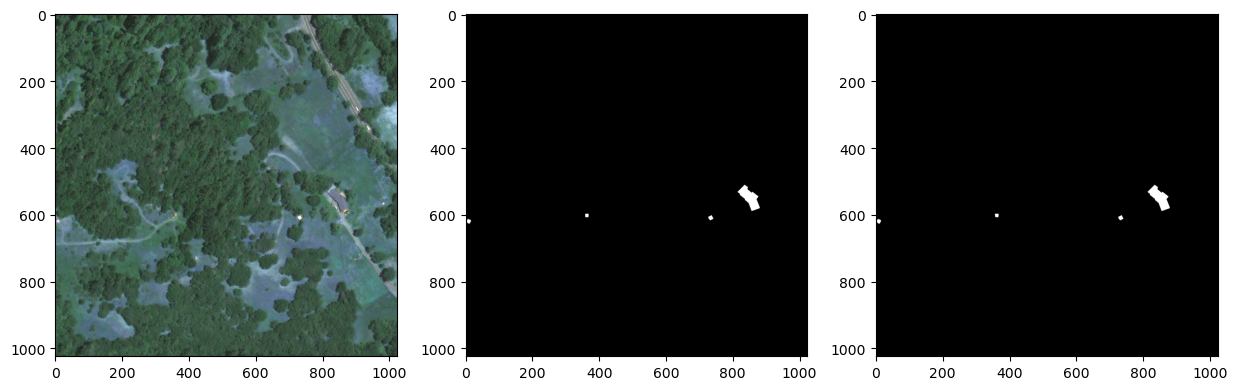

Ground truth non-zero: 2736
Created mask non-zero: 2741
Incorrect pixel count: 5 ( 0.183%)


np.float64(0.18274853801169588)

In [4]:
test_img_path = "./xBD_complete_png/hold/images/santa-rosa-wildfire_00000323_pre_disaster.png"
test_img_ground_truth_target_path = test_img_path.replace('images', 'targets').replace('.png', '_target.png')
test_img_lbl_path = test_img_path.replace('images', 'labels').replace('.png', '.json')

plt.figure(figsize=(15, 5))

test_img = cv2.imread(test_img_path)
plt.subplot(1, 3, 1)
plt.imshow(test_img)

test_img_ground_truth_target_img = cv2.imread(test_img_ground_truth_target_path, cv2.IMREAD_GRAYSCALE)
plt.subplot(1, 3, 2)
plt.imshow(test_img_ground_truth_target_img, cmap='gray')

mask_img = create_target_mask_from_label2(test_img_lbl_path)
plt.subplot(1, 3, 3)
plt.imshow(mask_img, cmap='gray')

plt.show()


check_target_error(mask_img, test_img_ground_truth_target_img, verbose=True)


# GeoTIFF variation

#### Since it doesnt provide any additional data and its size is too large, geotiff images are not used. Below is just a first look. Cells above this should be taken into consideration.
2025.08.06 

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


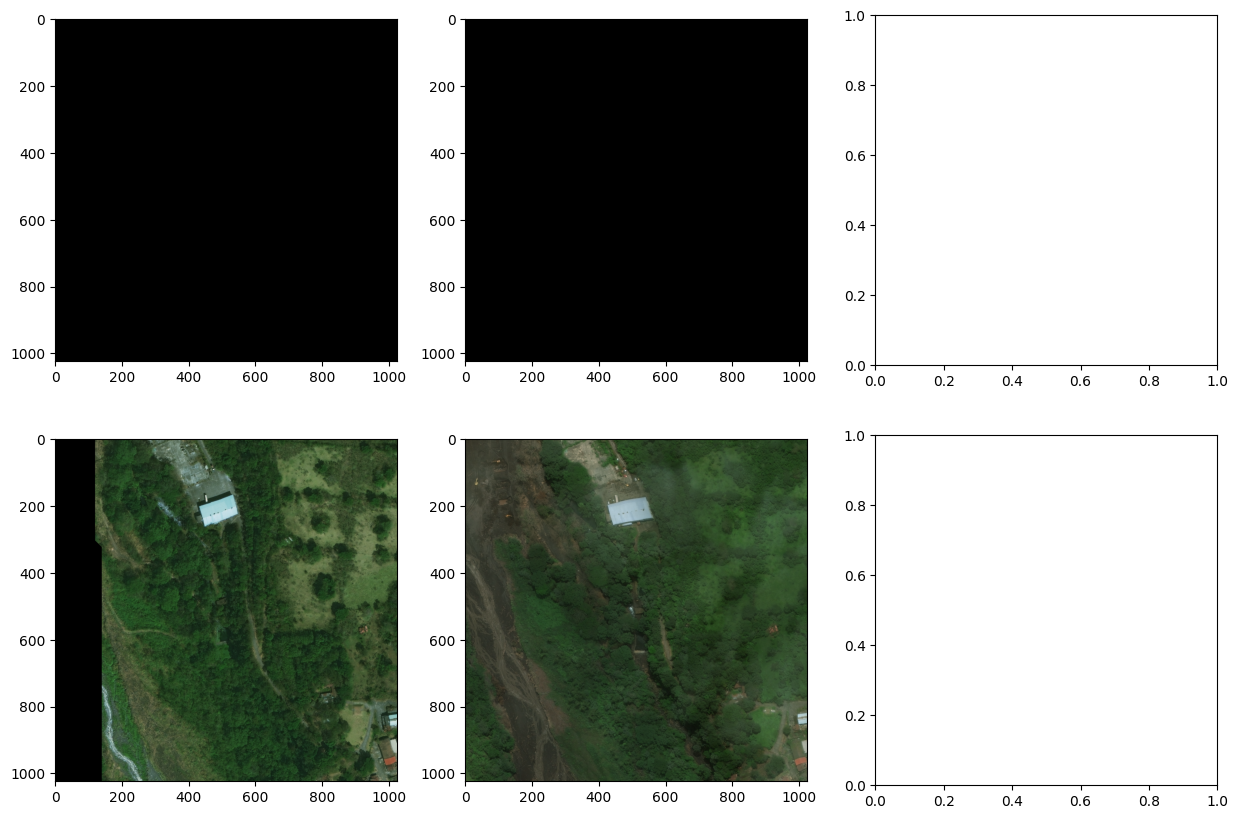

In [6]:
img_pre_cv  = cv2.imread('/storage/alperengenc/change_detection/Xbd2/geotiffs/tier1/images/guatemala-volcano_00000000_pre_disaster.tif')
img_post_cv = cv2.imread('/storage/alperengenc/change_detection/Xbd2/geotiffs/tier1/images/guatemala-volcano_00000000_post_disaster.tif')
# TODO img_target_cv = cv2.imread('', 0)
print(img_pre_cv.shape)
print(img_post_cv.shape)
# TODO print(img_target.shape, f"max={np.max(img_target)}")
plt.figure(figsize=(15, 10))

############ cv plots
plt.subplot(2, 3, 1)
plt.imshow(img_pre_cv)

plt.subplot(2, 3, 2)
plt.imshow(img_post_cv)

plt.subplot(2, 3, 3)
# TODO plt.imshow(img_target, cmap='gray')


############ tf plots
img_pre_tf  = tf.imread('/storage/alperengenc/change_detection/Xbd2/geotiffs/tier1/images/guatemala-volcano_00000000_pre_disaster.tif')
img_post_tf = tf.imread('/storage/alperengenc/change_detection/Xbd2/geotiffs/tier1/images/guatemala-volcano_00000000_post_disaster.tif')
# TODO img_target_tf = tf.imread('', 0)
print(img_pre_tf.shape)
print(img_post_tf.shape)
# TODO print(img_target_tf.shape, f"max={np.max(img_target_tf)}")

plt.subplot(2, 3, 4)
plt.imshow(img_pre_tf)

plt.subplot(2, 3, 5)
plt.imshow(img_post_tf)

plt.subplot(2, 3, 6)
# TODO plt.imshow(img_target_tf, cmap='gray')

plt.show()


In [10]:

label_pre  = json.load(open("/storage/alperengenc/change_detection/Xbd2/geotiffs/tier1/labels/guatemala-volcano_00000000_pre_disaster.json"))
label_post = json.load(open("/storage/alperengenc/change_detection/Xbd2/geotiffs/tier1/labels/guatemala-volcano_00000000_post_disaster.json"))
pprint(label_pre)

{'features': {'lng_lat': [{'properties': {'feature_type': 'building',
                                          'uid': '486b0813-ecd2-4b84-856c-9c0e42156953'},
                           'wkt': 'POLYGON ((-90.8154467949004 '
                                  '14.39086318334907, -90.81590706308027 '
                                  '14.39071123556949, -90.81587964154231 '
                                  '14.39059650626618, -90.81595559688809 '
                                  '14.3905736709202, -90.8159334443047 '
                                  '14.39048145754321, -90.81586635209149 '
                                  '14.39049581582651, -90.81584174451078 '
                                  '14.39043032648, -90.81537467349251 '
                                  '14.39060467857228, -90.8154467949004 '
                                  '14.39086318334907))'},
                          {'properties': {'feature_type': 'building',
                                          'uid': '139